# Texas Agriculture & Climate Data - EDA
## Exploring patterns in crop yields and weather (2000-2023)

**Team:** Carter Dobbs, Johann Steinhoff, Jay Suh  
**Course:** CS 4347 - Introduction to Machine Learning  
**November 2025**

---

This notebook explores our merged dataset combining USDA agricultural data with NOAA climate records for Texas. We're interested in understanding how weather patterns might affect crop production, which will inform our predictive modeling approach.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data

In [2]:
# Load our merged dataset
df = pd.read_csv("./texas_agriculture_with_climate_2000_2023.csv", low_memory=False)

print(f"Dataset dimensions: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"Total data points: {df.shape[0] * df.shape[1]:,} points")

Dataset dimensions: 398,204 rows x 120 columns
Total data points: 47,784,480 points


## Understanding our features

The 120 columns break down into a few categories:
- Agricultural metadata (crop types, measurement units, etc.)
- Climate measurements (monthly temp/precip data)
- Features we engineered (seasonal and annual aggregates)

In [3]:
# Group columns by category for easier analysis later
usda_columns = [
    "SOURCE_DESC",
    "SECTOR_DESC",
    "GROUP_DESC",
    "COMMODITY_DESC",
    "CLASS_DESC",
    "PRODN_PRACTICE_DESC",
    "UTIL_PRACTICE_DESC",
    "STATISTICCAT_DESC",
    "UNIT_DESC",
    "SHORT_DESC",
    "DOMAIN_DESC",
    "DOMAINCAT_DESC",
    "AGG_LEVEL_DESC",
]

location_columns = [
    "STATE_ANSI",
    "STATE_FIPS_CODE",
    "STATE_ALPHA",
    "STATE_NAME",
    "ASD_CODE",
    "ASD_DESC",
    "COUNTY_ANSI",
    "COUNTY_CODE",
    "COUNTY_NAME",
    "REGION_DESC",
    "ZIP_5",
    "WATERSHED_CODE",
    "WATERSHED_DESC",
    "CONGR_DISTRICT_CODE",
    "COUNTRY_CODE",
    "COUNTRY_NAME",
    "LOCATION_DESC",
    "COUNTY_FIPS",
]

temporal_columns = [
    "YEAR",
    "FREQ_DESC",
    "BEGIN_CODE",
    "END_CODE",
    "REFERENCE_PERIOD_DESC",
    "WEEK_ENDING",
    "LOAD_TIME",
]

# Monthly climate data
months = [
    "JAN",
    "FEB",
    "MAR",
    "APR",
    "MAY",
    "JUN",
    "JUL",
    "AUG",
    "SEP",
    "OCT",
    "NOV",
    "DEC",
]
precip_columns = [f"PRECIP_{m}" for m in months]
tmax_columns = [f"TMAX_{m}" for m in months]
tmin_columns = [f"TMIN_{m}" for m in months]
tavg_columns = [f"TAVG_{m}" for m in months]
cdd_columns = [f"CDD_{m}" for m in months]  # cooling degree days
hdd_columns = [f"HDD_{m}" for m in months]  # heating degree days

# Aggregated climate features we created
engineered_columns = [
    "GROWING_SEASON_PRECIP",
    "GROWING_SEASON_TEMP_AVG",
    "GROWING_SEASON_TEMP_MAX",
    "GROWING_SEASON_TEMP_MIN",
    "ANNUAL_PRECIP",
    "ANNUAL_TEMP_AVG",
    "ANNUAL_CDD",
    "ANNUAL_HDD",
]

## Column breakdown

Let's see what we're actually working with:

In [4]:
# Show what columns we have in each category
print("USDA AGRICULTURAL COLUMNS:")
print(f"({len([c for c in usda_columns if c in df.columns])} columns)")
for col in usda_columns:
    if col in df.columns:
        print(f"  - {col}")

print(f"\n\nLOCATION COLUMNS:")
print(f"({len([c for c in location_columns if c in df.columns])} columns)")
for col in location_columns:
    if col in df.columns:
        print(f"  - {col}")

print(f"\n\nTIME COLUMNS:")
print(f"({len([c for c in temporal_columns if c in df.columns])} columns)")
for col in temporal_columns:
    if col in df.columns:
        print(f"  - {col}")

print(f"\n\nMONTHLY CLIMATE COLUMNS:")
climate_cols = (
    precip_columns
    + tmax_columns
    + tmin_columns
    + tavg_columns
    + cdd_columns
    + hdd_columns
)
monthly_count = len([c for c in climate_cols if c in df.columns])
print(f"({monthly_count} columns)")
print("  Sample columns:")
print(f"    Precipitation: {[c for c in precip_columns if c in df.columns][:3]} ...")
print(f"    Max Temp: {[c for c in tmax_columns if c in df.columns][:3]} ...")
print(f"    Min Temp: {[c for c in tmin_columns if c in df.columns][:3]} ...")
print(f"    Avg Temp: {[c for c in tavg_columns if c in df.columns][:3]} ...")
print(f"    Cooling Degree Days: {[c for c in cdd_columns if c in df.columns][:3]} ...")
print(f"    Heating Degree Days: {[c for c in hdd_columns if c in df.columns][:3]} ...")

print(f"\n\nENGINEERED CLIMATE FEATURES:")
print(f"({len([c for c in engineered_columns if c in df.columns])} columns)")
for col in engineered_columns:
    if col in df.columns:
        print(f"  - {col}")

USDA AGRICULTURAL COLUMNS:
(13 columns)
  - SOURCE_DESC
  - SECTOR_DESC
  - GROUP_DESC
  - COMMODITY_DESC
  - CLASS_DESC
  - PRODN_PRACTICE_DESC
  - UTIL_PRACTICE_DESC
  - STATISTICCAT_DESC
  - UNIT_DESC
  - SHORT_DESC
  - DOMAIN_DESC
  - DOMAINCAT_DESC
  - AGG_LEVEL_DESC


LOCATION COLUMNS:
(18 columns)
  - STATE_ANSI
  - STATE_FIPS_CODE
  - STATE_ALPHA
  - STATE_NAME
  - ASD_CODE
  - ASD_DESC
  - COUNTY_ANSI
  - COUNTY_CODE
  - COUNTY_NAME
  - REGION_DESC
  - ZIP_5
  - WATERSHED_CODE
  - WATERSHED_DESC
  - CONGR_DISTRICT_CODE
  - COUNTRY_CODE
  - COUNTRY_NAME
  - LOCATION_DESC
  - COUNTY_FIPS


TIME COLUMNS:
(7 columns)
  - YEAR
  - FREQ_DESC
  - BEGIN_CODE
  - END_CODE
  - REFERENCE_PERIOD_DESC
  - WEEK_ENDING
  - LOAD_TIME


MONTHLY CLIMATE COLUMNS:
(72 columns)
  Sample columns:
    Precipitation: ['PRECIP_JAN', 'PRECIP_FEB', 'PRECIP_MAR'] ...
    Max Temp: ['TMAX_JAN', 'TMAX_FEB', 'TMAX_MAR'] ...
    Min Temp: ['TMIN_JAN', 'TMIN_FEB', 'TMIN_MAR'] ...
    Avg Temp: ['TAVG_JAN', 'T

## Missing data check

In [5]:
# Check which columns have missing values
missing_data = pd.DataFrame(
    {
        "Column": df.columns,
        "Missing": df.isnull().sum().values,
        "Percent": (df.isnull().sum().values / len(df) * 100),
    }
)
missing_data = missing_data[missing_data["Missing"] > 0].sort_values(
    "Percent", ascending=False
)

print(f"Columns with missing data: {len(missing_data)}/{len(df.columns)}")
print(f"Total missing: {missing_data['Missing'].sum():,}")
print(
    f"Overall completeness: {100 - (missing_data['Missing'].sum() / (len(df) * len(df.columns)) * 100):.1f}%"
)
print(f"\nTop columns with missing values:")
print(missing_data.head(10).to_string(index=False))

Columns with missing data: 88/120
Total missing: 3,348,024
Overall completeness: 93.0%

Top columns with missing values:
             Column  Missing    Percent
              ZIP_5   398204 100.000000
        REGION_DESC   398204 100.000000
CONGR_DISTRICT_CODE   398204 100.000000
     WATERSHED_DESC   398204 100.000000
        WEEK_ENDING   398204 100.000000
               CV_%   211970  53.231509
        COUNTY_ANSI    14133   3.549186
         PRECIP_JAN    14133   3.549186
         PRECIP_SEP    14133   3.549186
         PRECIP_FEB    14133   3.549186


### Column variance analysis

In [6]:
# Compute variance for all numeric columns to identify high-variance features
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
desc = df[num_cols].describe().T
desc["median"] = df[num_cols].median()
desc["skew"] = df[num_cols].skew()

cols_to_show = ["count", "min", "median", "mean", "std", "max", "skew"]
display(desc[cols_to_show].round(3))

top_var = df[num_cols].var().sort_values(ascending=False).head(10)
print("\nTop 10 numeric columns by variance:")
display(top_var)

print("\nNote: High variance in VALUE is expected since it measures different")
print(
    "units (dollars, bushels, acres). Feature scaling will be important for modeling."
)

,count,min,median,mean,std,max,skew
STATE_ANSI,398204.0,48.000,48.000,48.000,0.000,48.00,0.000
STATE_FIPS_CODE,398204.0,48.000,48.000,48.000,0.000,48.00,0.000
ASD_CODE,398204.0,11.000,51.000,49.134,27.868,99.00,0.179
COUNTY_ANSI,384071.0,1.000,233.000,246.936,147.435,507.00,0.095
COUNTY_CODE,398204.0,1.000,245.000,273.592,200.688,998.00,1.496
...,...,...,...,...,...,...,...
GROWING_SEASON_TEMP_MIN,384071.0,52.683,66.467,65.701,4.260,76.05,-0.587
ANNUAL_PRECIP,384071.0,2.970,30.550,32.514,14.551,95.03,0.609
ANNUAL_TEMP_AVG,384071.0,54.833,66.467,66.207,4.201,77.10,-0.186
ANNUAL_CDD,384071.0,923.000,2612.000,2630.563,679.476,4909.00,0.320



Top 10 numeric columns by variance:


ANNUAL_HDD     825516.534321
ANNUAL_CDD     461687.084531
COUNTY_CODE     40275.811177
COUNTY_FIPS     40275.811177
HDD_JAN         35928.917592
HDD_DEC         34259.376968
HDD_FEB         32347.354784
COUNTY_ANSI     21736.955659
HDD_NOV         20741.884111
HDD_MAR         18727.997060
dtype: float64


Note: High variance in VALUE is expected since it measures different
units (dollars, bushels, acres). Feature scaling will be important for modeling.


### Outlier detection (IQR method)

In [7]:
def iqr_outliers(s):
    """Identify outliers using the IQR (Interquartile Range) method."""
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    return s[(s < q1 - 1.5 * iqr) | (s > q3 + 1.5 * iqr)]


# Check key numeric columns for outliers
qa_numeric = [
    "ANNUAL_PRECIP",
    "ANNUAL_TEMP_AVG",
    "GROWING_SEASON_PRECIP",
    "VALUE_numeric",
]
qa_numeric = [c for c in qa_numeric if c in df.columns]

print("Outlier Analysis (using 1.5 x IQR rule):")
print("=" * 60)
for col in qa_numeric:
    s = df[col].dropna()
    out = iqr_outliers(s)
    print(f"\n{col}: {len(out)} outliers ({len(out)/len(df):.3%} of rows)")
    if len(out) > 0:
        print("Top 5 outlier values:")
        display(out.sort_values(ascending=False).head(5))

# Additional quality checks
dup_count = df.duplicated().sum()
print(f"\n{'='*60}")
print(f"Duplicate rows: {dup_count}")

if "ANNUAL_PRECIP" in df.columns:
    neg_precip = len(df[df["ANNUAL_PRECIP"] < 0])
    print(f"Negative precipitation rows: {neg_precip}")

print("\nNote: Climate outliers likely represent extreme weather events")
print("(droughts, floods) and should be retained for modeling.")

Outlier Analysis (using 1.5 x IQR rule):

ANNUAL_PRECIP: 1613 outliers (0.405% of rows)
Top 5 outlier values:


1532      95.03
1097      95.03
295479    95.03
293780    95.03
390391    95.03
Name: ANNUAL_PRECIP, dtype: float64


ANNUAL_TEMP_AVG: 5276 outliers (1.325% of rows)
Top 5 outlier values:


244212    77.1
1117      77.1
1466      77.1
2562      77.1
3264      77.1
Name: ANNUAL_TEMP_AVG, dtype: float64


GROWING_SEASON_PRECIP: 7381 outliers (1.854% of rows)
Top 5 outlier values:


394392    71.66
337       71.66
198       71.66
394708    71.66
385289    71.66
Name: GROWING_SEASON_PRECIP, dtype: float64


Duplicate rows: 0
Negative precipitation rows: 0

Note: Climate outliers likely represent extreme weather events
(droughts, floods) and should be retained for modeling.


## What's in the data?

In [8]:
# Quick look at the categorical variables
print(f"Counties covered: {df['COUNTY_NAME'].nunique()}")
print(f"Different crops: {df['COMMODITY_DESC'].nunique()}")
print(f"Statistic types: {df['STATISTICCAT_DESC'].nunique()}")

print(f"\nMost common crops:")
for crop, count in df["COMMODITY_DESC"].value_counts().head(5).items():
    print(f"  {crop}: {count:,} records")

print(f"\nTypes of measurements:")
for stat, count in df["STATISTICCAT_DESC"].value_counts().head(5).items():
    pct = count / len(df) * 100
    print(f"  {stat}: {count:,} ({pct:.1f}%)")

Counties covered: 256
Different crops: 165
Statistic types: 16

Most common crops:
  COTTON: 47,859 records
  WHEAT: 45,658 records
  SORGHUM: 27,754 records
  HAY: 22,679 records
  CORN: 21,495 records

Types of measurements:
  AREA HARVESTED: 166,318 (41.8%)
  PRODUCTION: 45,786 (11.5%)
  SALES: 32,474 (8.2%)
  AREA BEARING & NON-BEARING: 31,155 (7.8%)
  YIELD: 23,473 (5.9%)


## Data types and climate features

In [21]:
# Distribution of data types
print("Data types:")
for dtype, count in df.dtypes.value_counts().items():
    print(f"  {str(dtype):15s}: {count:3d} columns")

# Summary stats for our engineered climate features
print("\n\nClimate feature ranges:")
climate_stats = df[engineered_columns].describe().T
climate_stats["range"] = climate_stats["max"] - climate_stats["min"]
climate_stats[["min", "max", "mean", "std"]].round(2)

Data types:
  float64        :  91 columns
  object         :  24 columns
  int64          :   6 columns


Climate feature ranges:


,min,max,mean,std
GROWING_SEASON_PRECIP,1.53,71.66,18.95,8.94
GROWING_SEASON_TEMP_AVG,67.15,85.70,77.32,3.31
GROWING_SEASON_TEMP_MAX,81.30,98.68,88.92,3.11
GROWING_SEASON_TEMP_MIN,52.68,76.05,65.70,4.26
ANNUAL_PRECIP,2.97,95.03,32.51,14.55
ANNUAL_TEMP_AVG,54.83,77.10,66.21,4.20
ANNUAL_CDD,923.00,4909.00,2630.56,679.48
ANNUAL_HDD,340.00,4929.00,2158.47,908.58


## Dataset overview

In [10]:
# Put together a comprehensive summary
print("=" * 70)
print("DATASET SUMMARY".center(70))
print("=" * 70)

print(f"\nSize:")
print(f"  {df.shape[0]:,} records × {df.shape[1]} features")
print(f"  Memory: {df.memory_usage(deep=True).sum() / (1024**2):.1f} MB")

print(f"\nFeature breakdown:")
print(f"  Agricultural: {len([c for c in usda_columns if c in df.columns])}")
print(f"  Location: {len([c for c in location_columns if c in df.columns])}")
print(f"  Time: {len([c for c in temporal_columns if c in df.columns])}")
monthly_climate = len(
    [
        c
        for c in precip_columns
        + tmax_columns
        + tmin_columns
        + tavg_columns
        + cdd_columns
        + hdd_columns
        if c in df.columns
    ]
)
print(f"  Monthly climate: {monthly_climate}")
print(
    f"  Engineered climate: {len([c for c in engineered_columns if c in df.columns])}"
)

if "YEAR" in df.columns:
    print(f"\nTime coverage:")
    print(f"  {df['YEAR'].min()}-{df['YEAR'].max()} ({df['YEAR'].nunique()} years)")

    # Check census year pattern
    year_counts = df["YEAR"].value_counts().sort_index()
    census_years = [2002, 2007, 2012, 2017, 2022]
    census_avg = year_counts[year_counts.index.isin(census_years)].mean()
    non_census_avg = year_counts[~year_counts.index.isin(census_years)].mean()
    print(f"  Census years avg: {census_avg:,.0f} records")
    print(f"  Other years avg: {non_census_avg:,.0f} records")

if "COUNTY_NAME" in df.columns:
    print(f"\nGeography:")
    print(f"  {df['COUNTY_NAME'].nunique()} counties")

if "COMMODITY_DESC" in df.columns:
    print(f"\nAgriculture:")
    print(f"  {df['COMMODITY_DESC'].nunique()} commodities tracked")

if "STATISTICCAT_DESC" in df.columns:
    print(f"  {df['STATISTICCAT_DESC'].nunique()} measurement types")

print(f"\nData quality:")
total_missing = df.isnull().sum().sum()
total_cells = df.shape[0] * df.shape[1]
print(f"  {100 - (total_missing/total_cells)*100:.1f}% complete")
print(f"  {len(missing_data)}/{len(df.columns)} columns have missing values")

print("=" * 70)

                           DATASET SUMMARY                            

Size:
  398,204 records × 120 features
  Memory: 842.9 MB

Feature breakdown:
  Agricultural: 13
  Location: 18
  Time: 7
  Monthly climate: 72
  Engineered climate: 8

Time coverage:
  2000-2023 (24 years)
  Census years avg: 62,236 records
  Other years avg: 4,580 records

Geography:
  256 counties

Agriculture:
  165 commodities tracked
  16 measurement types

Data quality:
  Memory: 842.9 MB

Feature breakdown:
  Agricultural: 13
  Location: 18
  Time: 7
  Monthly climate: 72
  Engineered climate: 8

Time coverage:
  2000-2023 (24 years)
  Census years avg: 62,236 records
  Other years avg: 4,580 records

Geography:
  256 counties

Agriculture:
  165 commodities tracked
  16 measurement types

Data quality:
  93.0% complete
  88/120 columns have missing values
  93.0% complete
  88/120 columns have missing values


## Visualizations

Let's look at what crops dominate the dataset:

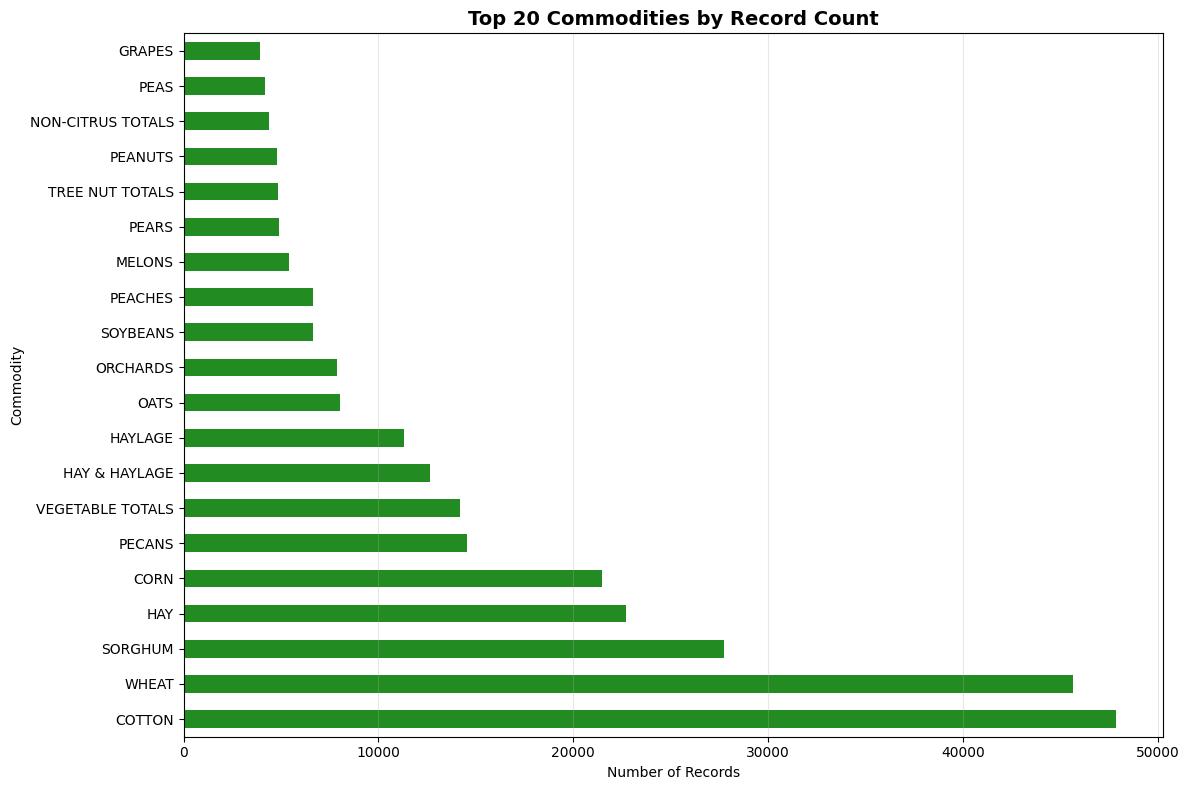

In [11]:
# Top commodities in the dataset
plt.figure(figsize=(12, 8))
df["COMMODITY_DESC"].value_counts().head(20).plot(kind="barh", color="forestgreen")
plt.title("Top 20 Commodities by Record Count", fontsize=14, fontweight="bold")
plt.xlabel("Number of Records")
plt.ylabel("Commodity")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

### Geographic climate patterns

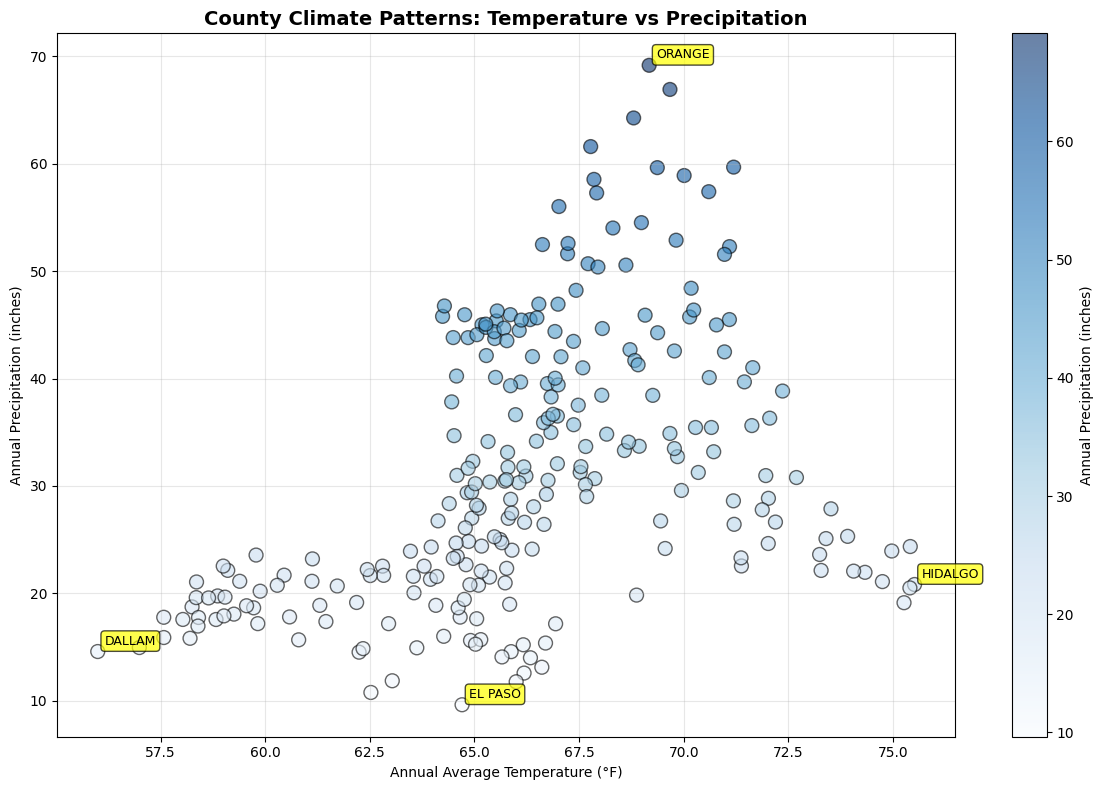

In [12]:
# Scatter: precipitation vs temperature by county
county_climate = (
    df.groupby("COUNTY_NAME")[["ANNUAL_PRECIP", "ANNUAL_TEMP_AVG"]].mean().dropna()
)

plt.figure(figsize=(12, 8))
plt.scatter(
    county_climate["ANNUAL_TEMP_AVG"],
    county_climate["ANNUAL_PRECIP"],
    alpha=0.6,
    s=100,
    c=county_climate["ANNUAL_PRECIP"],
    cmap="Blues",
    edgecolors="black",
)
plt.colorbar(label="Annual Precipitation (inches)")
plt.title(
    "County Climate Patterns: Temperature vs Precipitation",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("Annual Average Temperature (°F)")
plt.ylabel("Annual Precipitation (inches)")
plt.grid(True, alpha=0.3)

# Annotate a few extremes
wettest = county_climate.nlargest(1, "ANNUAL_PRECIP").index[0]
driest = county_climate.nsmallest(1, "ANNUAL_PRECIP").index[0]
hottest = county_climate.nlargest(1, "ANNUAL_TEMP_AVG").index[0]
coolest = county_climate.nsmallest(1, "ANNUAL_TEMP_AVG").index[0]

for county in [wettest, driest, hottest, coolest]:
    row = county_climate.loc[county]
    plt.annotate(
        county,
        (row["ANNUAL_TEMP_AVG"], row["ANNUAL_PRECIP"]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
    )

plt.tight_layout()
plt.show()

### What types of measurements do we have?

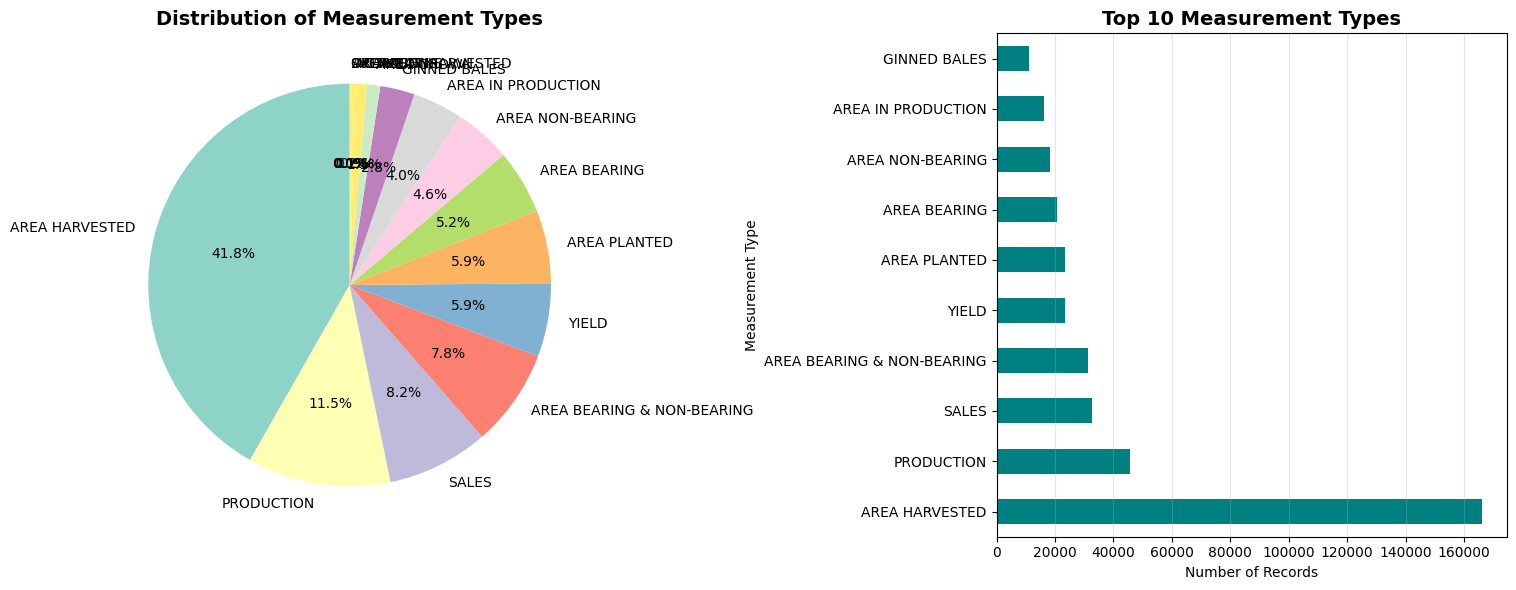

In [13]:
# Breakdown of statistic types
stat_counts = df["STATISTICCAT_DESC"].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart
colors = plt.cm.Set3(range(len(stat_counts)))
ax1.pie(
    stat_counts.values,
    labels=stat_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
)
ax1.set_title("Distribution of Measurement Types", fontsize=14, fontweight="bold")

# Bar chart for top 10
stat_counts.head(10).plot(kind="barh", ax=ax2, color="teal")
ax2.set_title("Top 10 Measurement Types", fontsize=14, fontweight="bold")
ax2.set_xlabel("Number of Records")
ax2.set_ylabel("Measurement Type")
ax2.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.show()

### Data collection over time

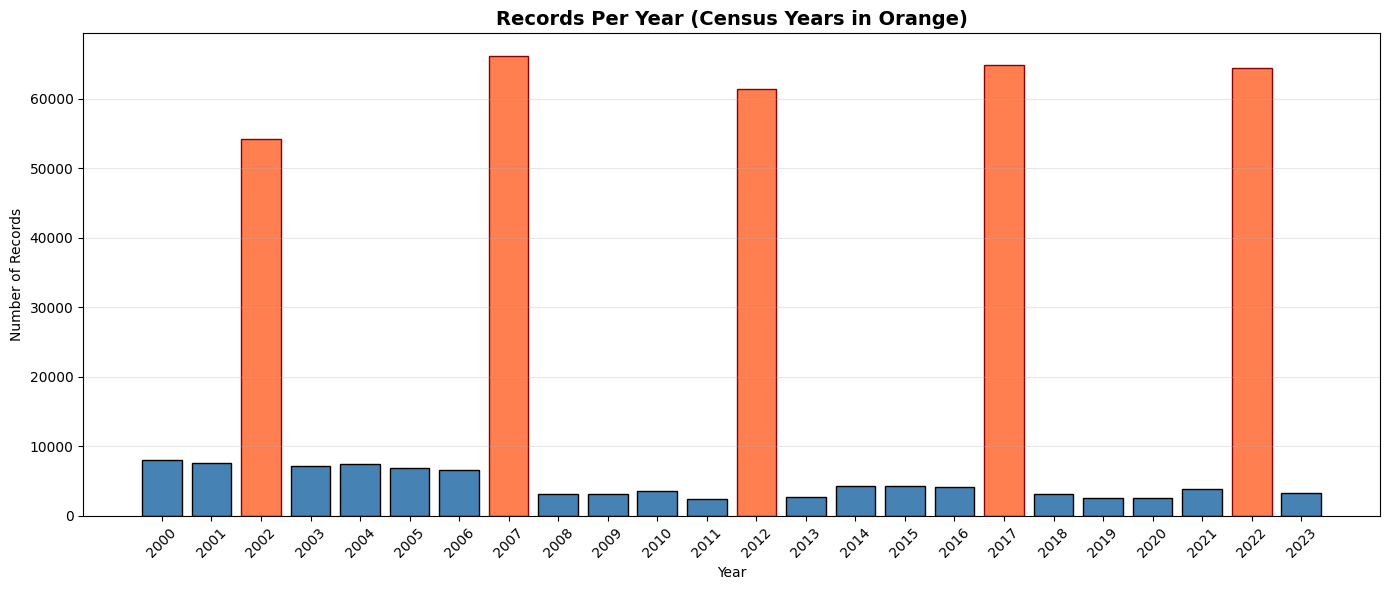

Census years have 13.6x more records than non-census years


In [14]:
# Records per year - shows census year pattern
year_counts = df["YEAR"].value_counts().sort_index()
census_years = [2002, 2007, 2012, 2017, 2022]

plt.figure(figsize=(14, 6))
bars = plt.bar(
    year_counts.index, year_counts.values, color="steelblue", edgecolor="black"
)

# Highlight census years
for i, year in enumerate(year_counts.index):
    if year in census_years:
        bars[i].set_color("coral")
        bars[i].set_edgecolor("darkred")

plt.title("Records Per Year (Census Years in Orange)", fontsize=14, fontweight="bold")
plt.xlabel("Year")
plt.ylabel("Number of Records")
plt.xticks(year_counts.index, rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print(
    f"Census years have {census_avg/non_census_avg:.1f}x more records than non-census years"
)

### Climate trends over time

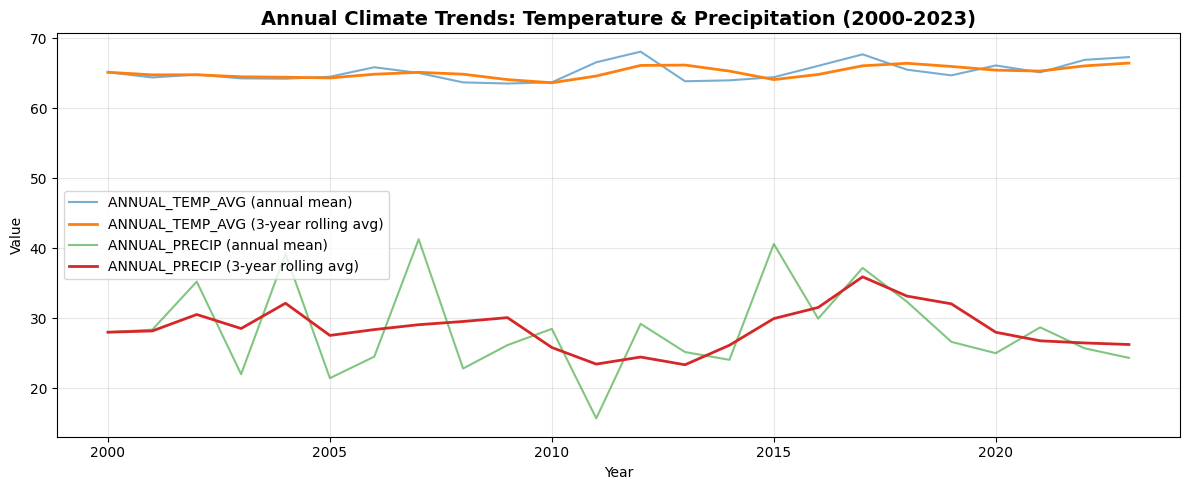


Note: 3-year rolling average smooths year-to-year variability
to reveal longer-term trends. Look for overall warming or
changes in precipitation patterns over the 24-year period.


In [15]:
# Analyze climate trends across the 24-year period
trend_cols = [c for c in ["ANNUAL_TEMP_AVG", "ANNUAL_PRECIP"] if c in df.columns]
if "YEAR" in df.columns and len(trend_cols) > 0:
    annual = df.groupby("YEAR")[trend_cols].mean().dropna()

    plt.figure(figsize=(12, 5))
    for col in trend_cols:
        plt.plot(annual.index, annual[col], label=f"{col} (annual mean)", alpha=0.6)
        plt.plot(
            annual.index,
            annual[col].rolling(3, min_periods=1).mean(),
            label=f"{col} (3-year rolling avg)",
            linewidth=2,
        )

    plt.title(
        "Annual Climate Trends: Temperature & Precipitation (2000-2023)",
        fontsize=14,
        fontweight="bold",
    )
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\nNote: 3-year rolling average smooths year-to-year variability")
    print("to reveal longer-term trends. Look for overall warming or")
    print("changes in precipitation patterns over the 24-year period.")

### How do climate features correlate?

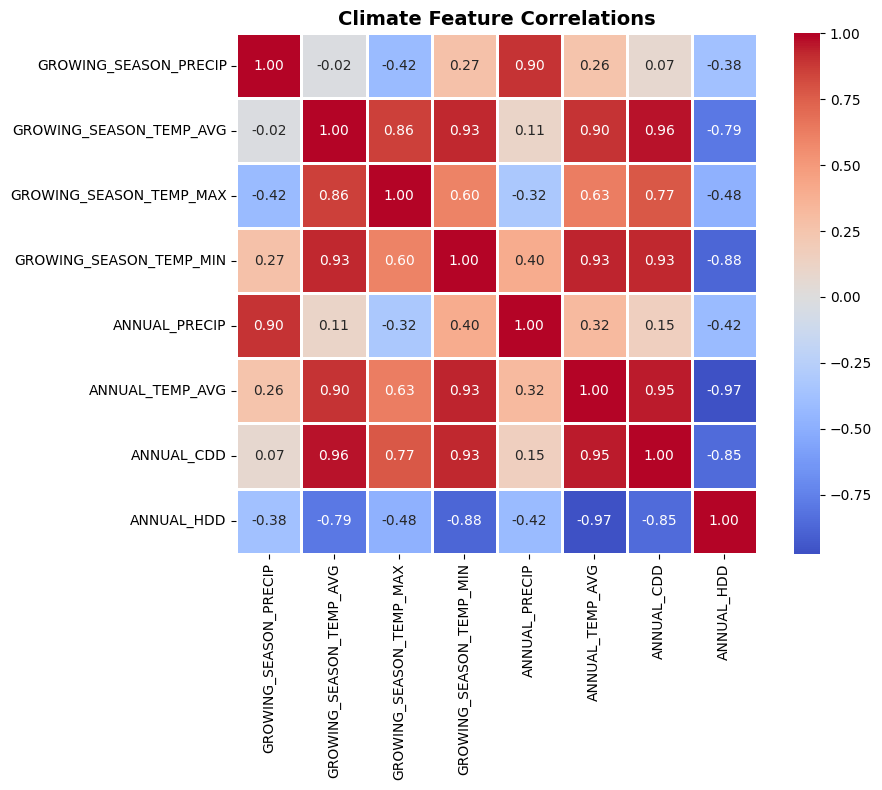

In [16]:
# Correlation between our engineered climate features
climate_features = [col for col in engineered_columns if col in df.columns]
if len(climate_features) > 0:
    plt.figure(figsize=(10, 8))
    corr_matrix = df[climate_features].corr()
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        square=True,
        linewidths=1,
    )
    plt.title("Climate Feature Correlations", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

### Climate variable distributions

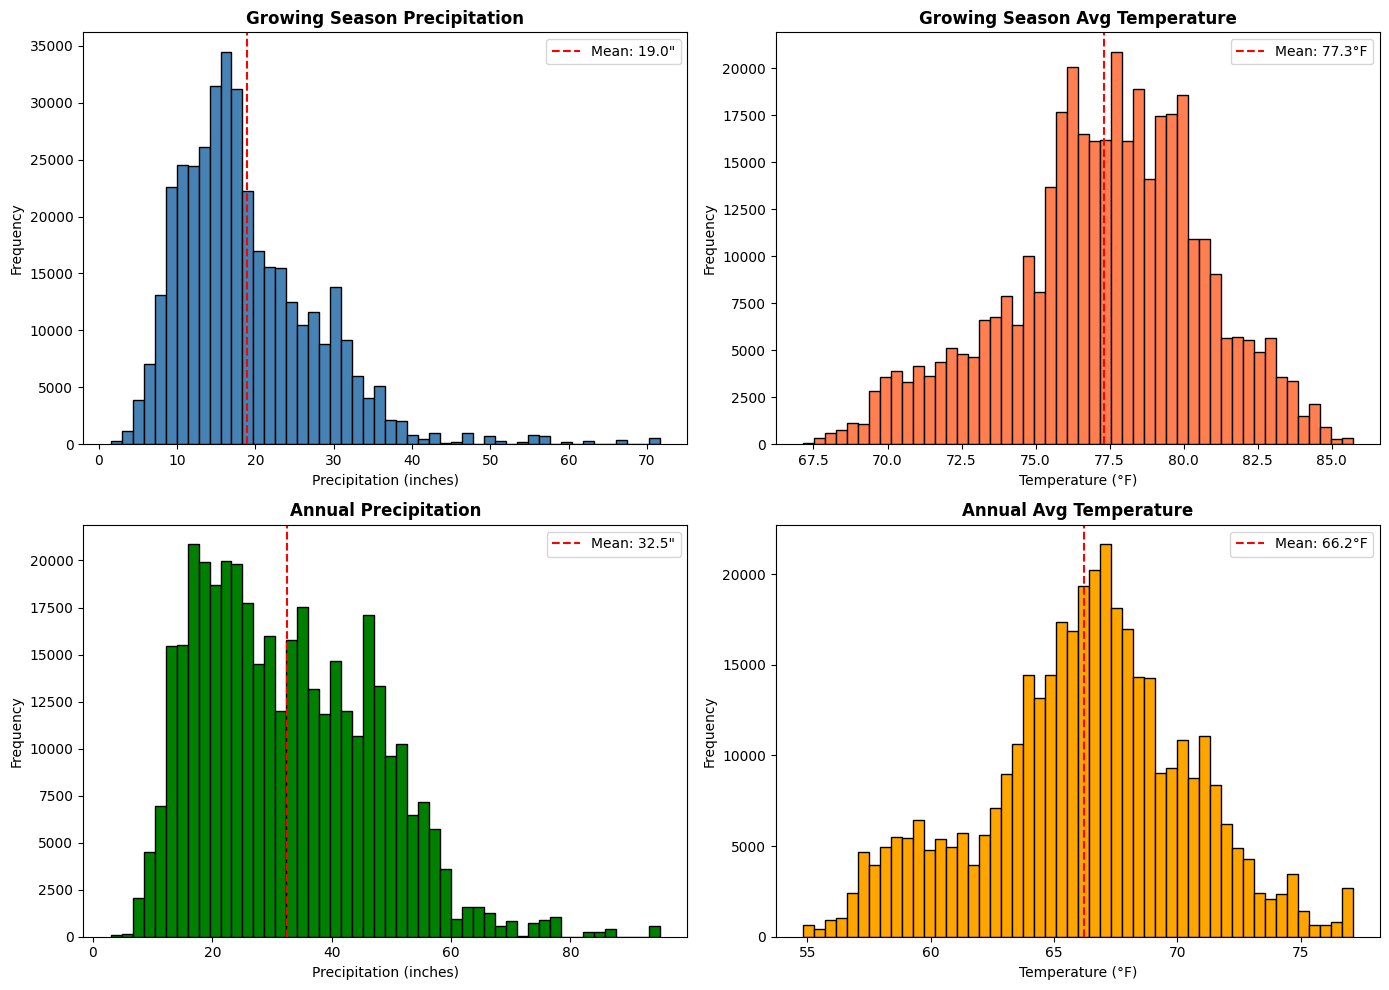

In [17]:
# Distribution plots for key climate variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Growing season precip
axes[0, 0].hist(
    df["GROWING_SEASON_PRECIP"].dropna(), bins=50, color="steelblue", edgecolor="black"
)
axes[0, 0].set_title("Growing Season Precipitation", fontweight="bold")
axes[0, 0].set_xlabel("Precipitation (inches)")
axes[0, 0].set_ylabel("Frequency")
mean_precip = df["GROWING_SEASON_PRECIP"].mean()
axes[0, 0].axvline(
    mean_precip, color="red", linestyle="--", label=f'Mean: {mean_precip:.1f}"'
)
axes[0, 0].legend()

# Growing season temp
axes[0, 1].hist(
    df["GROWING_SEASON_TEMP_AVG"].dropna(), bins=50, color="coral", edgecolor="black"
)
axes[0, 1].set_title("Growing Season Avg Temperature", fontweight="bold")
axes[0, 1].set_xlabel("Temperature (°F)")
axes[0, 1].set_ylabel("Frequency")
mean_temp = df["GROWING_SEASON_TEMP_AVG"].mean()
axes[0, 1].axvline(
    mean_temp, color="red", linestyle="--", label=f"Mean: {mean_temp:.1f}°F"
)
axes[0, 1].legend()

# Annual precip
axes[1, 0].hist(df["ANNUAL_PRECIP"].dropna(), bins=50, color="green", edgecolor="black")
axes[1, 0].set_title("Annual Precipitation", fontweight="bold")
axes[1, 0].set_xlabel("Precipitation (inches)")
axes[1, 0].set_ylabel("Frequency")
mean_annual_precip = df["ANNUAL_PRECIP"].mean()
axes[1, 0].axvline(
    mean_annual_precip,
    color="red",
    linestyle="--",
    label=f'Mean: {mean_annual_precip:.1f}"',
)
axes[1, 0].legend()

# Annual temp
axes[1, 1].hist(
    df["ANNUAL_TEMP_AVG"].dropna(), bins=50, color="orange", edgecolor="black"
)
axes[1, 1].set_title("Annual Avg Temperature", fontweight="bold")
axes[1, 1].set_xlabel("Temperature (°F)")
axes[1, 1].set_ylabel("Frequency")
mean_annual_temp = df["ANNUAL_TEMP_AVG"].mean()
axes[1, 1].axvline(
    mean_annual_temp,
    color="red",
    linestyle="--",
    label=f"Mean: {mean_annual_temp:.1f}°F",
)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### Regional climate patterns

In [18]:
# Average climate by county
county_climate = (
    df.groupby("COUNTY_NAME")[["ANNUAL_PRECIP", "ANNUAL_TEMP_AVG"]].mean().dropna()
)

print("Wettest counties (annual precipitation):")
print(county_climate.nlargest(10, "ANNUAL_PRECIP")[["ANNUAL_PRECIP"]].round(1))

print("\n\nDriest counties:")
print(county_climate.nsmallest(10, "ANNUAL_PRECIP")[["ANNUAL_PRECIP"]].round(1))

print("\n\nHottest counties (annual avg temp):")
print(county_climate.nlargest(10, "ANNUAL_TEMP_AVG")[["ANNUAL_TEMP_AVG"]].round(1))

print("\n\nCoolest counties:")
print(county_climate.nsmallest(10, "ANNUAL_TEMP_AVG")[["ANNUAL_TEMP_AVG"]].round(1))

Wettest counties (annual precipitation):
             ANNUAL_PRECIP
COUNTY_NAME               
ORANGE                69.1
JEFFERSON             66.9
HARDIN                64.2
NEWTON                61.6
GALVESTON             59.7
LIBERTY               59.6
CHAMBERS              58.9
JASPER                58.5
HARRIS                57.4
TYLER                 57.3


Driest counties:
             ANNUAL_PRECIP
COUNTY_NAME               
EL PASO                9.6
HUDSPETH              10.8
REEVES                11.8
CULBERSON             11.9
LOVING                12.6
BREWSTER              13.1
WARD                  14.0
PRESIDIO              14.1
GAINES                14.5
PECOS                 14.6


Hottest counties (annual avg temp):
             ANNUAL_TEMP_AVG
COUNTY_NAME                 
HIDALGO                 75.5
CAMERON                 75.4
STARR                   75.4
ZAPATA                  75.3
WILLACY                 75.0
KENEDY                  74.7
BROOKS                

### Does climate affect yields?

In [19]:
# Look at yield correlations for major crops
df["VALUE_numeric"] = pd.to_numeric(df["VALUE"], errors="coerce")

# Focus on yield stats for major crops
major_crops = ["COTTON", "WHEAT", "CORN", "SORGHUM"]
yield_data = df[
    (df["STATISTICCAT_DESC"] == "YIELD") & (df["COMMODITY_DESC"].isin(major_crops))
].copy()

if len(yield_data) > 0:
    print("Correlation: Growing Season Precipitation vs Crop Yield")
    print("-" * 60)
    for crop in major_crops:
        crop_data = yield_data[yield_data["COMMODITY_DESC"] == crop]
        if len(crop_data) > 100:  # need enough data points
            corr = (
                crop_data[["GROWING_SEASON_PRECIP", "VALUE_numeric"]].corr().iloc[0, 1]
            )
            print(f"{crop:12s}: {corr:6.3f}")

    print("\n\nCorrelation: Growing Season Temperature vs Crop Yield")
    print("-" * 60)
    for crop in major_crops:
        crop_data = yield_data[yield_data["COMMODITY_DESC"] == crop]
        if len(crop_data) > 100:
            corr = (
                crop_data[["GROWING_SEASON_TEMP_AVG", "VALUE_numeric"]]
                .corr()
                .iloc[0, 1]
            )
            print(f"{crop:12s}: {corr:6.3f}")

    print("\n(Values range -1 to 1: positive = yield increases with variable,")
    print(" negative = yield decreases with variable)")
else:
    print("Not enough yield data for correlation analysis")

Correlation: Growing Season Precipitation vs Crop Yield
------------------------------------------------------------
COTTON      :  0.239
WHEAT       :  0.164
CORN        : -0.166
SORGHUM     :  0.286


Correlation: Growing Season Temperature vs Crop Yield
------------------------------------------------------------
COTTON      : -0.102
WHEAT       : -0.115
CORN        : -0.704
SORGHUM     :  0.059

(Values range -1 to 1: positive = yield increases with variable,
 negative = yield decreases with variable)


## Key Takeaways

**Dataset scope:**
- ~398k records spanning 24 years (2000-2023) across all 256 Texas counties
- 165 commodities tracked, but cotton, wheat, and sorghum dominate (top 5 crops = ~165k records)
- Census years (every 5 years) have way more data - 62k avg vs 4.6k avg for other years

**Data quality:**
- 93% complete overall - pretty good
- Most missing values are in administrative fields (ZIP codes, regions, etc. are 100% missing)
- Climate measurements are 96.5% complete

**Climate patterns we noticed:**
- Temperature variables are highly correlated, which makes sense
- Precipitation ranges from ~3 to 95 inches annually (mean: 32.5")
- Clear regional differences: east Texas is wetter, south is hotter, west is drier
- Correlations between climate and yields vary a lot by crop - corn really doesn't like heat (r = -0.70)

**For modeling:**
- The strong temperature correlations suggest we could reduce dimensionality there
- Definitely need to account for census year effects - that's a huge data imbalance
- The climate outliers are real weather events (droughts, floods), not errors - keep them
- Might need separate models for different statistic types since "Area Harvested" dominates (42%)